# Detecting open doors using object detection
This notebooks uses an RTSP camera to acquire images and send them to LandngLens for analysis

In [3]:
#@title Set the following variables as needed for your setup
api_key         = "dvkyqd942h90wn1t3fsbjshsud3xdgs"  #@param {type:"string"}
api_secret      = "gj95e8antnkhcduuwrgok3efrtwpzqojykc05l8yiuxnaecxdqxvawrir0d3yw"  #@param {type:"string"}
# In order to find the URL for your camera, this is a good start https://www.ispyconnect.com/cameras
# camera_url      =  "rtsp://172.25.101.151/ch0_0.h264" #@param {type:"string"}
# camera_url      =  './sample_images/door_%02d.jpg' # Use sample images
camera_url      =  0 # Connect to local webcam
model_endpoint  =  "c0791de7-66e3-4970-9a87-064e5e3b07ee" #@param {type:"string"}

In [4]:
# Load LandingLens library from the local repo
import sys, os
sys.path.append("../../modules/src")

In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Acquire image from camera

In [5]:
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image

# Open connection to camera
vcap = cv2.VideoCapture(camera_url)

# Capture frame-by-frame
ret, frame = vcap.read()

# Convert color space to RGB
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Show the captured image
plt.imshow(frame)
plt.title(camera_url)
plt.show()

error: ignored

## Run the object detection model on LandingLens cloud

In [ ]:
from landingai.predict import Predictor
from landingai.visualize import draw_bboxes
        
predictor = Predictor(model_endpoint, api_key, api_secret)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

[{'id': '3a5bf9c3-d9db-4a99-b77a-49339d34cbcf',
  'label': 'Closed',
  'confidence_score': 0.8824453949928284,
  'bboxes': {'xmin': 926, 'ymin': 269, 'xmax': 1243, 'ymax': 1064}}]

## Visualize results

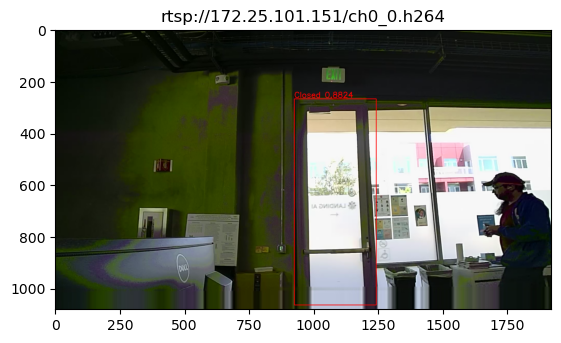

In [ ]:
# Draw raw results on the original image
frame = draw_bboxes(results, image=frame)
plt.imshow(frame)
plt.title(camera_url)
plt.show()


## Process results to determine if the door is open or closed

In [ ]:
from IPython.display import display, Markdown
# For better accuracy we look at the top detection and only claim that hte door is closed if we identify it as such. If the door is partially open or fully open it will be reported as open
top_detection = max(results, key=lambda x: x['confidence_score'])
if top_detection['label'] == "Closed":
    display(Markdown('# The door is not open'))
else:
    display(Markdown('# The door is open'))


# The door is not open